# Описание набора данных
В этом конкурсе вам предстоит спрогнозировать продажи тысяч семейств товаров, продаваемых в магазинах Favorita, расположенных в Эквадоре. Данные для обучения включают даты, информацию о магазине и товаре, о том, рекламировался ли данный товар, а также цифры продаж. Дополнительные файлы содержат дополнительную информацию, которая может быть полезна при построении ваших моделей.

# Описания файлов и информация о полях данных
### train.csv
Данные об обучении, включающие временные ряды функций store_nbr, family и onpromotion, а также целевые продажи.
store_nbr определяет магазин, в котором продаются продукты.
family определяет тип продаваемого продукта.
sales показывает общий объем продаж для семейства продуктов в конкретном магазине на заданную дату. 

Возможны дробные значения, поскольку продукты могут продаваться дробными единицами (например, 1,5 кг сыра, а не 1 пакетик чипсов).
onpromotion показывает общее количество наименований в семействе продуктов, которые продавались в магазине на определенную дату.
### test.csv
Тестовые данные, имеющие те же характеристики, что и данные для обучения. Вы будете прогнозировать целевые продажи на даты в этом файле.
Даты в тестовых данных относятся к 15 дням после последней даты в данных для обучения.
### sample_submission.csv
Пример файла для отправки в нужном формате.
### stores.csv
Хранит метаданные, включая город, штат, тип и кластер.
Кластер - это группа похожих магазинов.
### oil.csv
Ежедневная цена на нефть. Включает значения как за период подготовки, так и за период тестирования данных. (Эквадор - страна, зависящая от нефти, и ее экономическое состояние сильно зависит от скачков цен на нефть.)
### holidays_events.csv
Праздники и события с метаданными

ПРИМЕЧАНИЕ: Обратите особое внимание на столбец "Перенесенный". Официально перенесенный праздничный день приходится на этот календарный день, но правительство перенесло его на другую дату. Перенесенный день больше похож на обычный день, чем на праздничный. Чтобы найти день, в который он на самом деле отмечался, найдите соответствующую строку, где тип - Перевод. Например, праздник Независимости Гуаякиля был перенесен с 2012-10-09 на 2012-10-12, что означает, что он отмечался в 2012-10-12 годах. Дни, относящиеся к типу Bridge, - это дополнительные дни, которые добавляются к праздничному дню (например, для продления перерыва на длинные выходные). Они часто связаны с типом рабочего дня, который обычно не запланирован для работы (например, суббота) и который предназначен для окупаемости проекта Bridge.
Дополнительные праздничные дни - это дни, добавленные к обычным календарным выходным, например, как это обычно бывает перед Рождеством (что делает канун Рождества выходным днем).
# Дополнительные примечания
Заработная плата в государственном секторе выплачивается каждые две недели 15-го и в последний день месяца. Это может повлиять на продажи в супермаркетах.

16 апреля 2016 года в Эквадоре произошло землетрясение магнитудой 7,8. Люди объединились для оказания помощи, жертвуя воду и другие товары первой необходимости, что сильно повлияло на продажи в супермаркетах в течение нескольких недель после землетрясения.

# EDA

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df = pd.read_csv(os.path.join(dirname, filename))
        print(df.describe())
        print('')
        print(df.head())
        print('-------------------------')

/kaggle/input/store-sales-time-series-forecasting/oil.csv
        dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000

         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
-------------------------
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
                 id    sales
count  2.851200e+04  28512.0
mean   3.015144e+06      0.0
std    8.230850e+03      0.0
min    3.000888e+06      0.0
25%    3.008016e+06      0.0
50%    3.015144e+06      0.0
75%    3.022271e+06      0.0
max    3.029399e+06      0.0

        id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0
-------------------------
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
              date     type    locale locale_name 

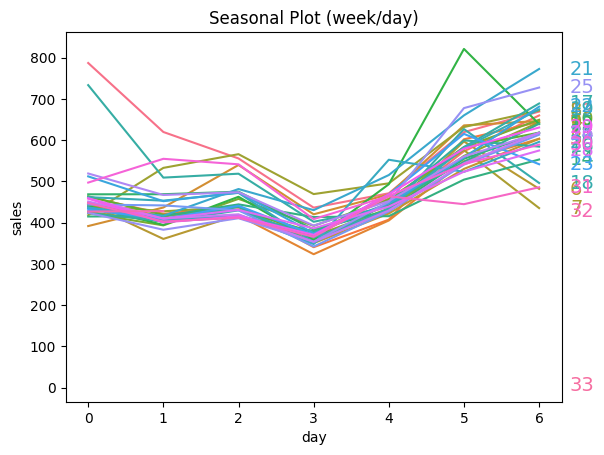

In [3]:
from learntools.time_series.utils import plot_periodogram, seasonal_plot

# Выгрузим данные
store_sales = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

average_sales = (
    store_sales
    .groupby('date').agg({'sales':'mean'})
    .squeeze()
    .loc['2017']
)

X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

График показывает сезонность внутри недели

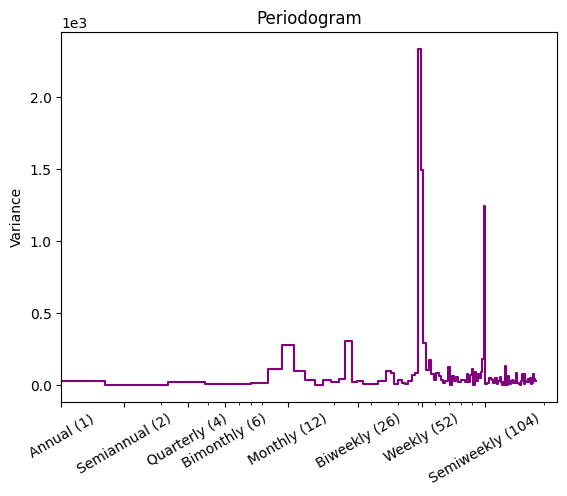

In [4]:
plot_periodogram(average_sales);

Периодограмма показывает наличие полунедельной, недельной, двухнедельной и месячной сезонности.

### Вывод
Для предсказания будущих продаж используем данные о сезонности продаж

# Pipeline

In [5]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import Ridge

y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Создание факторов сезонности Фурье
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

# Разделим данные на учебный и тренировочный набор для проверки
max_date = y.index.max()
train_end = max_date - 15
X_train, X_test = X.loc[:train_end], X.loc[train_end+1:]
y_train, y_test = y.loc[:train_end], y.loc[train_end+1:]

X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

# Создадим пайплайн и обучим модель
# Используем пайплайн для предобработки данных
simple_imputer = SimpleImputer(strategy='median')
std_scaler = StandardScaler()

pipe_num = Pipeline([('imputer', simple_imputer), ('scaler', std_scaler)])

s_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
pipe_cat = Pipeline([('imputer', s_imputer), ('encoder', ohe_encoder)])

col_transformer = ColumnTransformer([('num_preproc', pipe_num, [x for x in X_train.columns if X_train[x].dtype!='object']),
                                     ('cat_preproc', pipe_cat, [x for x in X_train.columns if X_train[x].dtype=='object'])])

# Для анализа выберем Ridge
model = Ridge()

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model)])

final_pipe.fit(X_train, y_train)
y_pred = pd.DataFrame(final_pipe.predict(X_test),columns=y_test.columns, index=X_test.index)

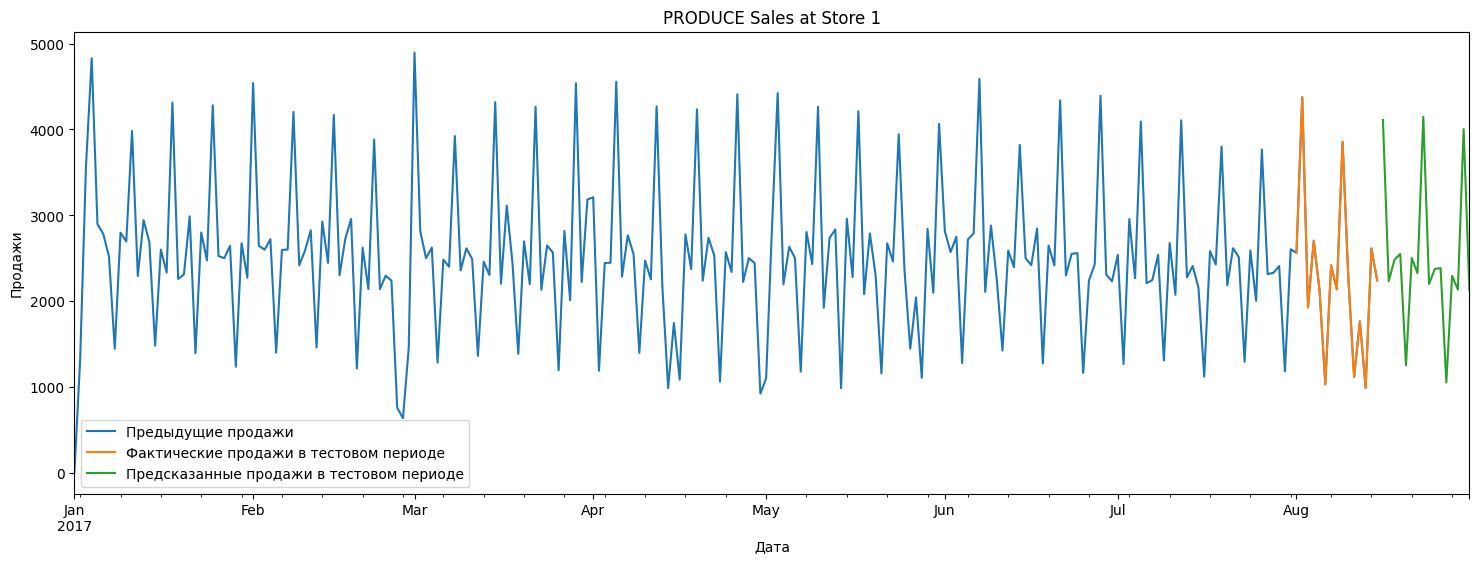

In [6]:
import matplotlib.pyplot as plt

# Выведем на график сравнение реальных и предсказанных продаж
STORE_NBR = '1'
FAMILY = 'PRODUCE'

fig, ax = plt.subplots(figsize=(18, 6))
y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, label='Предыдущие продажи')
y_test.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, label='Фактические продажи в тестовом периоде')
y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, label='Предсказанные продажи в тестовом периоде')
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')
ax.set_xlabel('Дата')
ax.set_ylabel('Продажи')
ax.legend()
plt.show()

Модель работает, можно обучать тестовый датафрейм

In [7]:
# Создание факторов сезонности Фурье
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

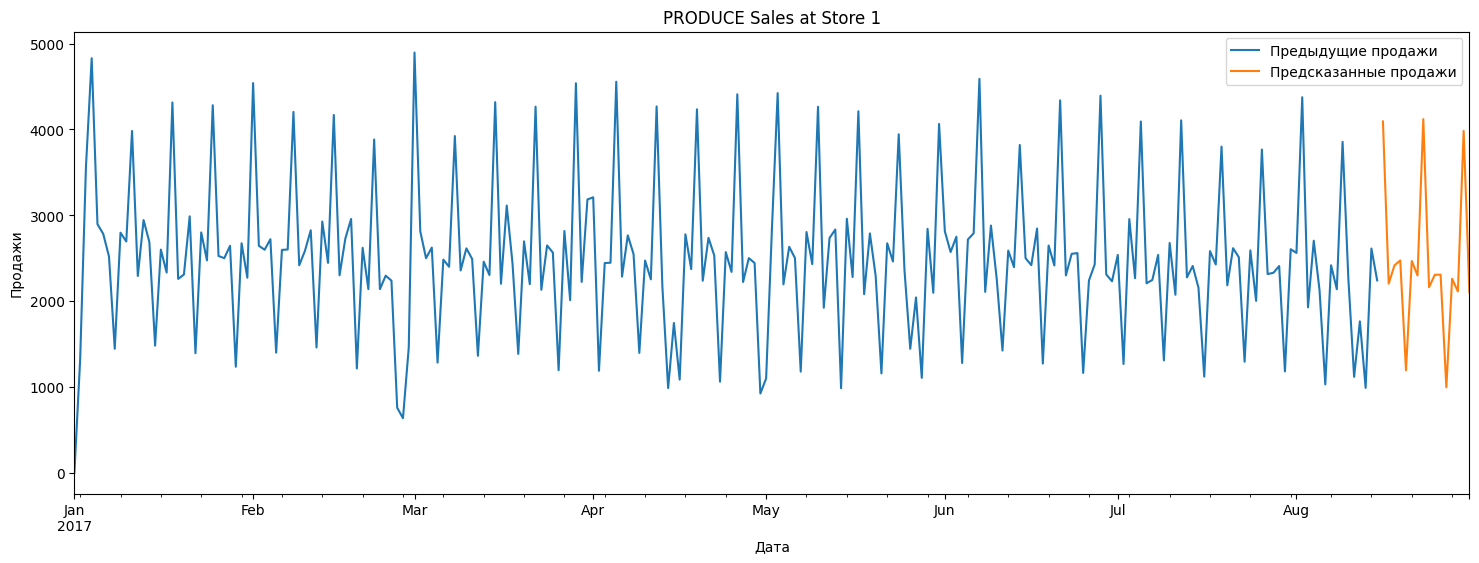

In [8]:
final_pipe.fit(X, y)
y_pred = pd.DataFrame(final_pipe.predict(X_test),columns=y_test.columns, index=X_test.index)

STORE_NBR = '1'
FAMILY = 'PRODUCE'

fig, ax = plt.subplots(figsize=(18, 6))
y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, label='Предыдущие продажи')
y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, label='Предсказанные продажи')
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')
ax.set_xlabel('Дата')
ax.set_ylabel('Продажи')
ax.legend()
plt.show()

# Submission

In [9]:
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

y_submit = pd.DataFrame(final_pipe.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_2.csv', index=False)